In [31]:
import twitter_info

import tweepy
from imdb import IMDb

import time
import json
import pandas as pd
import numpy as np
from iteration_utilities import deepflatten
from datetime import datetime
import os
import re
import glob
from tqdm import tqdm

from nltk.tokenize import word_tokenize
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
lm = WordNetLemmatizer()
from nltk.stem.porter import PorterStemmer
pm = PorterStemmer()

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

import codecs
from glove import Corpus, Glove
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.models import FastText

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import silhouette_samples, silhouette_score
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sn

from pickle import dump
from pickle import load

In [4]:
%run helper_functions.ipynb

In [5]:
final_input_df = pd.read_csv("output/final_output/final_input_cleaned_stem_lemma.csv")

In [6]:
final_input_df['label_id'] = final_input_df['label'].astype("category").cat.codes
final_input_df

,full_text,label,stem_cleaned_tokens,lemma_cleaned_tokens,label_id
0,‘#GuardiansoftheGalaxy 3’ Star #KarenGillan Sa...,Marvel Cinematic Universe,"['guardiansofthegalaxi', 'star', 'karengillan'...","['guardiansofthegalaxy', 'star', 'karengillan'...",1
1,My friend recommend me a few shows and I have ...,DC Extended Universe,"['friend', 'show', 'idea', 'flash', 'guy', 'sh...","['friend', 'show', 'idea', 'flash', 'guy', 'sh...",0
2,@Papa__Drago Godzilla would win easily but jus...,MonsterVerse,"['papa', 'drago', 'godzilla', 'hundr', 'titan'...","['papa', 'drago', 'godzilla', 'titan', 'omg']",2
3,Batman &amp; Robin...It's so camp https://t.co...,DC Extended Universe,"['batman', 'robin', 'camp']","['batman', 'robin', 'camp']",0
4,why is huge ant man moving so slow,Marvel Cinematic Universe,"['ant', 'man', 'move']","['ant', 'man']",1
...,...,...,...,...,...
51457,@tortoisethatwon @aightmoe @Sarcasm_bender End...,DC Extended Universe,"['tortoisethatwon', 'aightmo', 'sarcasm', 'ben...","['tortoisethatwon', 'aightmoe', 'sarcasm', 'be...",0
51458,@iHrtProngs SIRIUS BLACK DOES NOT HAVE A BAD H...,Wizarding World,"['hair', 'day']","['ihrtprongs', 'hair', 'day']",4
51459,@aNorthernGarden @fiona_skywalker Agreed. She ...,Star Wars,"['fiona', 'skywalk', 'liter', 'ask', 'comment'...","['fiona', 'skywalker', 'input', 'earns', 'hous...",3
51460,And so my long Marvel-watching journey comes t...,Marvel Cinematic Universe,"['marvel-watch', 'journey', 'caught', 'endless...","['journey', 'end', 'franchise', 'eon', 'rest',...",1


In [7]:
final_input_df['label_id'] = final_input_df['label'].astype("category").cat.codes
final_input_df

,full_text,label,stem_cleaned_tokens,lemma_cleaned_tokens,label_id
0,‘#GuardiansoftheGalaxy 3’ Star #KarenGillan Sa...,Marvel Cinematic Universe,"['guardiansofthegalaxi', 'star', 'karengillan'...","['guardiansofthegalaxy', 'star', 'karengillan'...",1
1,My friend recommend me a few shows and I have ...,DC Extended Universe,"['friend', 'show', 'idea', 'flash', 'guy', 'sh...","['friend', 'show', 'idea', 'flash', 'guy', 'sh...",0
2,@Papa__Drago Godzilla would win easily but jus...,MonsterVerse,"['papa', 'drago', 'godzilla', 'hundr', 'titan'...","['papa', 'drago', 'godzilla', 'titan', 'omg']",2
3,Batman &amp; Robin...It's so camp https://t.co...,DC Extended Universe,"['batman', 'robin', 'camp']","['batman', 'robin', 'camp']",0
4,why is huge ant man moving so slow,Marvel Cinematic Universe,"['ant', 'man', 'move']","['ant', 'man']",1
...,...,...,...,...,...
51457,@tortoisethatwon @aightmoe @Sarcasm_bender End...,DC Extended Universe,"['tortoisethatwon', 'aightmo', 'sarcasm', 'ben...","['tortoisethatwon', 'aightmoe', 'sarcasm', 'be...",0
51458,@iHrtProngs SIRIUS BLACK DOES NOT HAVE A BAD H...,Wizarding World,"['hair', 'day']","['ihrtprongs', 'hair', 'day']",4
51459,@aNorthernGarden @fiona_skywalker Agreed. She ...,Star Wars,"['fiona', 'skywalk', 'liter', 'ask', 'comment'...","['fiona', 'skywalker', 'input', 'earns', 'hous...",3
51460,And so my long Marvel-watching journey comes t...,Marvel Cinematic Universe,"['marvel-watch', 'journey', 'caught', 'endless...","['journey', 'end', 'franchise', 'eon', 'rest',...",1


In [8]:
df_vectorization = final_input_df[['stem_cleaned_tokens', 'label', 'label_id']]
df_vectorization.head()

,stem_cleaned_tokens,label,label_id
0,"['guardiansofthegalaxi', 'star', 'karengillan'...",Marvel Cinematic Universe,1
1,"['friend', 'show', 'idea', 'flash', 'guy', 'sh...",DC Extended Universe,0
2,"['papa', 'drago', 'godzilla', 'hundr', 'titan'...",MonsterVerse,2
3,"['batman', 'robin', 'camp']",DC Extended Universe,0
4,"['ant', 'man', 'move']",Marvel Cinematic Universe,1


In [9]:
dfvg = df_vectorization.groupby(['label', 'label_id'])
classes = {}
for d in dfvg:
    classes[d[0][1]] = d[0][0]
print(classes)

{0: 'DC Extended Universe', 1: 'Marvel Cinematic Universe', 2: 'MonsterVerse', 3: 'Star Wars', 4: 'Wizarding World'}


In [10]:
df_embedding = final_input_df[['lemma_cleaned_tokens', 'label', 'label_id']]
df_embedding.head()

,lemma_cleaned_tokens,label,label_id
0,"['guardiansofthegalaxy', 'star', 'karengillan'...",Marvel Cinematic Universe,1
1,"['friend', 'show', 'idea', 'flash', 'guy', 'sh...",DC Extended Universe,0
2,"['papa', 'drago', 'godzilla', 'titan', 'omg']",MonsterVerse,2
3,"['batman', 'robin', 'camp']",DC Extended Universe,0
4,"['ant', 'man']",Marvel Cinematic Universe,1


In [11]:
df_vectorization = df_vectorization.drop_duplicates(subset='stem_cleaned_tokens', keep="first")
df_vectorization = df_vectorization.reset_index(drop=True)
df_embedding = df_embedding.drop_duplicates(subset='lemma_cleaned_tokens', keep="first")
df_embedding = df_embedding.reset_index(drop=True)

In [12]:
df_vectorization.shape

(47353, 3)

In [13]:
df_embedding.shape

(46685, 3)

In [14]:
%%time
list_stemmed_data = []
list_embedding_data = []
drop_stemmed_index = []
drop_lemma_index = []
for i in df_vectorization.index:
    exec("lst = " + df_vectorization['stem_cleaned_tokens'][i])
    lst = clean_tokens(lst)
    if(len(lst) == 0 or lst[0] == ''):
        drop_stemmed_index.append(i)
    list_stemmed_data.append(" ".join(lst))
for i in df_embedding.index:
    exec("lst2 = " + df_embedding['lemma_cleaned_tokens'][i])
    lst2 = clean_tokens(lst2)
    if(len(lst2) == 0 or lst2[0] == ''):
         drop_lemma_index.append(i)
    list_embedding_data.append(" ".join(lst2))

CPU times: total: 14 s
Wall time: 14.3 s


In [15]:
df_vectorization.drop(index=drop_stemmed_index, inplace = True)
df_vectorization = df_vectorization.reset_index(drop=True)
df_embedding.drop(index=drop_lemma_index, inplace = True)
df_embedding = df_embedding.reset_index(drop=True)
for i in drop_stemmed_index:
    del list_stemmed_data[i]
for i in drop_lemma_index:
    del list_embedding_data[i]

In [16]:
len(df_vectorization), len(list_stemmed_data)

(47348, 47348)

In [17]:
len(df_embedding), len(list_embedding_data)

(46683, 46683)

In [18]:
df_vectorization['label'].value_counts()

Marvel Cinematic Universe    10098
DC Extended Universe          9558
MonsterVerse                  9388
Star Wars                     9195
Wizarding World               9109
Name: label, dtype: int64

In [19]:
%%time
tf_idf_vectorizer = TfidfVectorizer(ngram_range = (1,3), analyzer='word', min_df=2)
vectorized_text=tf_idf_vectorizer.fit_transform(list_stemmed_data)

CPU times: total: 5.25 s
Wall time: 5.45 s


In [20]:
tf_idf_vectors = tf_idf_vectorizer.get_feature_names_out()
tf_idf_vectors

array(['abaddon', 'abaga', 'abaga eniolamaf', ..., 'zuri whitak',
       'zxshadowacexz', 'zypisfi'], dtype=object)

In [21]:
len(tf_idf_vectors)

77023

In [22]:
%%time
X_sv=vectorized_text
y_sv=list(df_vectorization['label_id'])
print(X_sv.shape)
print(len(y_sv))
X_train_sv, X_valid_sv, y_train_sv, y_valid_sv = train_test_split(X_sv, y_sv, test_size = 0.3, shuffle = True, stratify = y_sv, random_state = 3)

(47348, 77023)
47348
CPU times: total: 46.9 ms
Wall time: 44 ms


In [37]:
%%time
from sklearn.cluster import KMeans, DBSCAN
'''Sum_of_squared_distances = []
K = range(2,10)
for k in K:
    km = KMeans(n_clusters=k, max_iter=200, n_init=10)
    km = km.fit(X_sv)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()'''

CPU times: total: 0 ns
Wall time: 0 ns


"Sum_of_squared_distances = []\nK = range(2,10)\nfor k in K:\n    km = KMeans(n_clusters=k, max_iter=200, n_init=10)\n    km = km.fit(X_sv)\n    Sum_of_squared_distances.append(km.inertia_)\nplt.plot(K, Sum_of_squared_distances, 'bx-')\nplt.xlabel('k')\nplt.ylabel('Sum_of_squared_distances')\nplt.title('Elbow Method For Optimal k')\nplt.show()"

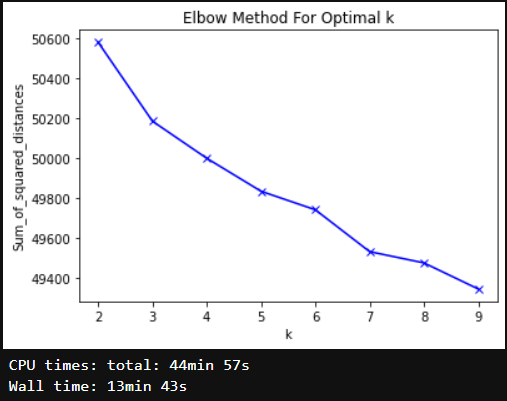

In [24]:
classes

{0: 'DC Extended Universe',
 1: 'Marvel Cinematic Universe',
 2: 'MonsterVerse',
 3: 'Star Wars',
 4: 'Wizarding World'}

### Elbow point appears at 5 and 7 so lets take k = 7

In [27]:
%%time
true_k = 7
title = df_vectorization['label']
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
model.fit(X_sv)
labels=model.labels_
universe_cl=pd.DataFrame(list(zip(title,labels)),columns=['title','cluster'])
print(universe_cl.sort_values(by=['cluster']))

                           title  cluster
0      Marvel Cinematic Universe        0
27056            Wizarding World        0
27055       DC Extended Universe        0
27053            Wizarding World        0
27052            Wizarding World        0
...                          ...      ...
23541               MonsterVerse        6
13093               MonsterVerse        6
38070               MonsterVerse        6
30538               MonsterVerse        6
22234               MonsterVerse        6

[47348 rows x 2 columns]
CPU times: total: 9min 19s
Wall time: 2min 1s


Cluster: 0
Titles


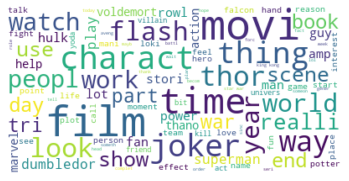

Cluster: 1
Titles


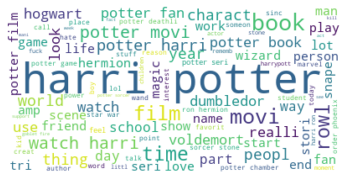

Cluster: 2
Titles


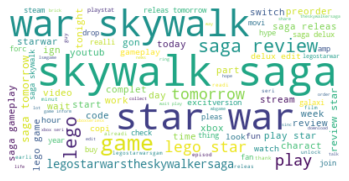

Cluster: 3
Titles


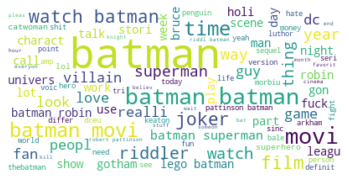

Cluster: 4
Titles


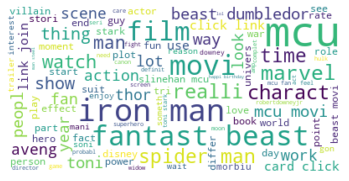

Cluster: 5
Titles


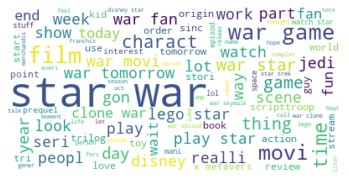

Cluster: 6
Titles


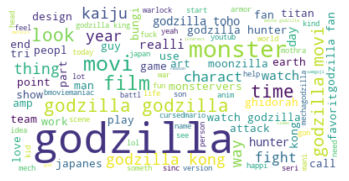

In [28]:
from wordcloud import WordCloud
result={'cluster':labels,'reviews':list_stemmed_data}
result=pd.DataFrame(result)
for k in range(0,true_k):
    s=result[result.cluster==k]
    text=s['reviews'].str.cat(sep=' ')
    text=text.lower()
    text=' '.join([word for word in text.split()])
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    print('Cluster: {}'.format(k))
    print('Titles')
    titles=universe_cl[universe_cl.cluster==k]['title']         
    #print(titles.to_string(index=False))
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [29]:
for k in range(true_k):
    print("Value Counts for cluster = ", k)
    print(universe_cl[universe_cl.cluster == k].value_counts())
    print("========================================================")

Value Counts for cluster =  0
title                      cluster
Marvel Cinematic Universe  0          7188
DC Extended Universe       0          7166
Wizarding World            0          4239
MonsterVerse               0          3797
Star Wars                  0          3640
dtype: int64
Value Counts for cluster =  1
title                      cluster
Wizarding World            1          4166
Star Wars                  1            15
Marvel Cinematic Universe  1             5
DC Extended Universe       1             3
MonsterVerse               1             2
dtype: int64
Value Counts for cluster =  2
title                      cluster
Star Wars                  2          1058
Marvel Cinematic Universe  2             1
dtype: int64
Value Counts for cluster =  3
title                      cluster
DC Extended Universe       3          2186
Marvel Cinematic Universe  3            23
MonsterVerse               3            20
Wizarding World            3            11
Star Wars    

In [32]:
%%time
sample_silhouette_values = silhouette_samples(X_sv, model.labels_)
print(f"Silhouette values:")
silhouette_values = []
for i in range(true_k):
    cluster_silhouette_values = sample_silhouette_values[model.labels_ == i]
    silhouette_values.append((i,
    cluster_silhouette_values.shape[0],
    cluster_silhouette_values.mean(),
    cluster_silhouette_values.min(),
    cluster_silhouette_values.max(),))
silhouette_values = sorted(silhouette_values, key=lambda tup: tup[2], reverse=True)
for s in silhouette_values:
    print(f"    Cluster {s[0]}: Size:{s[1]} | Avg:{s[2]:.2f} | Min:{s[3]:.2f} | Max: {s[4]:.2f}")

Silhouette values:
    Cluster 2: Size:1059 | Avg:0.08 | Min:0.03 | Max: 0.21
    Cluster 1: Size:4191 | Avg:0.04 | Min:0.00 | Max: 0.17
    Cluster 3: Size:2242 | Avg:0.03 | Min:-0.01 | Max: 0.14
    Cluster 6: Size:5521 | Avg:0.02 | Min:-0.01 | Max: 0.10
    Cluster 5: Size:4543 | Avg:0.01 | Min:-0.03 | Max: 0.06
    Cluster 4: Size:3762 | Avg:0.01 | Min:-0.02 | Max: 0.06
    Cluster 0: Size:26030 | Avg:-0.00 | Min:-0.05 | Max: 0.01
CPU times: total: 1min 5s
Wall time: 1min 5s


The value of the Silhouette score varies from -1 to 1. 
If the score is 1, the cluster is dense and well-separated than other clusters. 
A value near 0 represents overlapping clusters with samples very close to the decision boundary of the neighboring clusters. 
A negative score [-1, 0] indicates that the samples might have got assigned to the wrong clusters.

In [ ]:

model = DBSCAN(eps = 5, min_samples = 200, n_jobs=-1)
model.fit(X_sv)